# Speed of Sound Prior Example
The machinary and the explanation of them is identical to those found in the Piecewise Polytropic, Speed of Sound, and Tabulated Examples.

In [1]:
import neost
from neost.eos import speedofsound
from neost.Prior import Prior
from neost.Star import Star
from neost.Likelihood import Likelihood
from neost import PosteriorAnalysis
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib
from matplotlib import pyplot
from pymultinest.solve import solve
import time
import os
#if not os.path.exists("chains"): 
#   os.mkdir("chains")

import neost.global_imports as global_imports

# Some physical constants
c = global_imports._c
G = global_imports._G
Msun = global_imports._M_s
pi = global_imports._pi
rho_ns = global_imports._rhons

# Define name for run
run_name = "prior-hebeler-cs-"

# We're exploring a speed of sound (CS) EoS parametrization with a chiral effective field theory (cEFT) parametrization based on Hebeler's work
# Transition between CS parametrisation and cEFT parametrization occurs at 1.1*saturation density
speedofsound_cs = speedofsound.SpeedofSoundEoS(crust = 'ceft-Hebeler', rho_t = 1.1*rho_ns)

using c code


In [2]:
# Create the likelihoods for the individual measurements
mass_radius_j0740 = np.load('../../examples/j0740.npy').T
J0740_LL = gaussian_kde(mass_radius_j0740)

# Pass the likelihoods to the solver
likelihood_functions = [J0740_LL.pdf]
likelihood_params = [['Mass', 'Radius']]

# Define whether event is GW or not and define number of stars/events
chirp_mass = [None, None]
number_stars = len(chirp_mass)

In [3]:
# Define variable parameters, same prior as previous papers of Raaijmakers et al
variable_params={'ceft':[speedofsound_cs.min_norm, speedofsound_cs.max_norm],'a1':[0.1,1.5],'a2':[1.5,12.],'a3':[0.075,24.],'a4':[1.5,37.],'a5':[0.1,1.]}
for i in range(number_stars):
    variable_params.update({'rhoc_' + str(i+1):[14.6, 16]})

# Define static parameters, empty dict because all params are variable 
static_params={}

# Define prior
prior = Prior(speedofsound_cs, variable_params, static_params, chirp_mass)

print("Bounds of prior are")
print(variable_params)
print("number of parameters is %d" %len(variable_params))

# Define likelihood, pseudo_var is required as input because NEoST expects to be able to pass the parameter sample drawn from the prior to be passable to the likelihood
def loglike(pseudo_var):
    return 1.

Bounds of prior are
{'ceft': [1.676, 2.814], 'a1': [0.1, 1.5], 'a2': [1.5, 12.0], 'a3': [0.075, 24.0], 'a4': [1.5, 37.0], 'a5': [0.1, 1.0], 'rhoc_1': [14.6, 16], 'rhoc_2': [14.6, 16]}
number of parameters is 8


In [4]:
# No prior & likelihood test, there is no likelihood after all
# print("Testing prior and likelihood")
# cube = np.random.rand(50, len(variable_params))
# for i in range(len(cube)):
#     par = prior.inverse_sample(cube[i])
#     print(likelihood.call(par))
# print("Testing done")

In [5]:
# Then we start the sampling, note the greatly increased number of livepoints, this is required because each livepoint terminates after 1 iteration
start = time.time()
result = solve(LogLikelihood=loglike, Prior=prior.inverse_sample, n_live_points=10000, evidence_tolerance=0.1,
               n_dims=len(variable_params), sampling_efficiency=0.8, outputfiles_basename='../../examples/chains/' + run_name, verbose=True)
end = time.time()
print(end - start)

  analysing data from ../../examples/chains/prior-hebeler-cs-.txt
957.856472492218


Total number of samples is 10000
|████████████████████████████████████████| 10000/10000 [100%] in 31:38.7 (5.27/s) 
sample too small for 10000000000000000.00
sample too small for 2.35
sample too small for 2.40
sample too small for 2.46
sample too small for 2.51
sample too small for 2.57
sample too small for 2.62
sample too small for 2.68
sample too small for 2.73
sample too small for 2.79
sample too small for 2.84
sample too small for 2.90


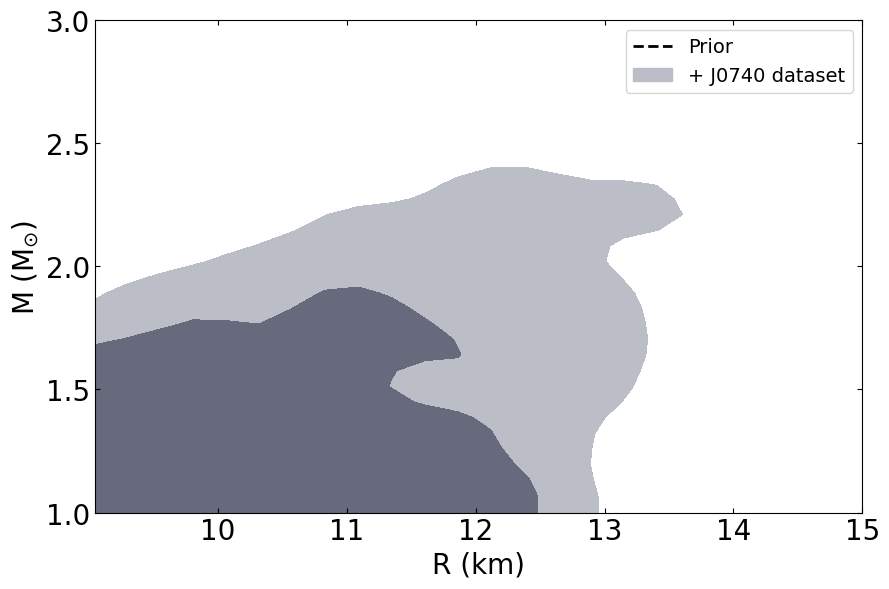

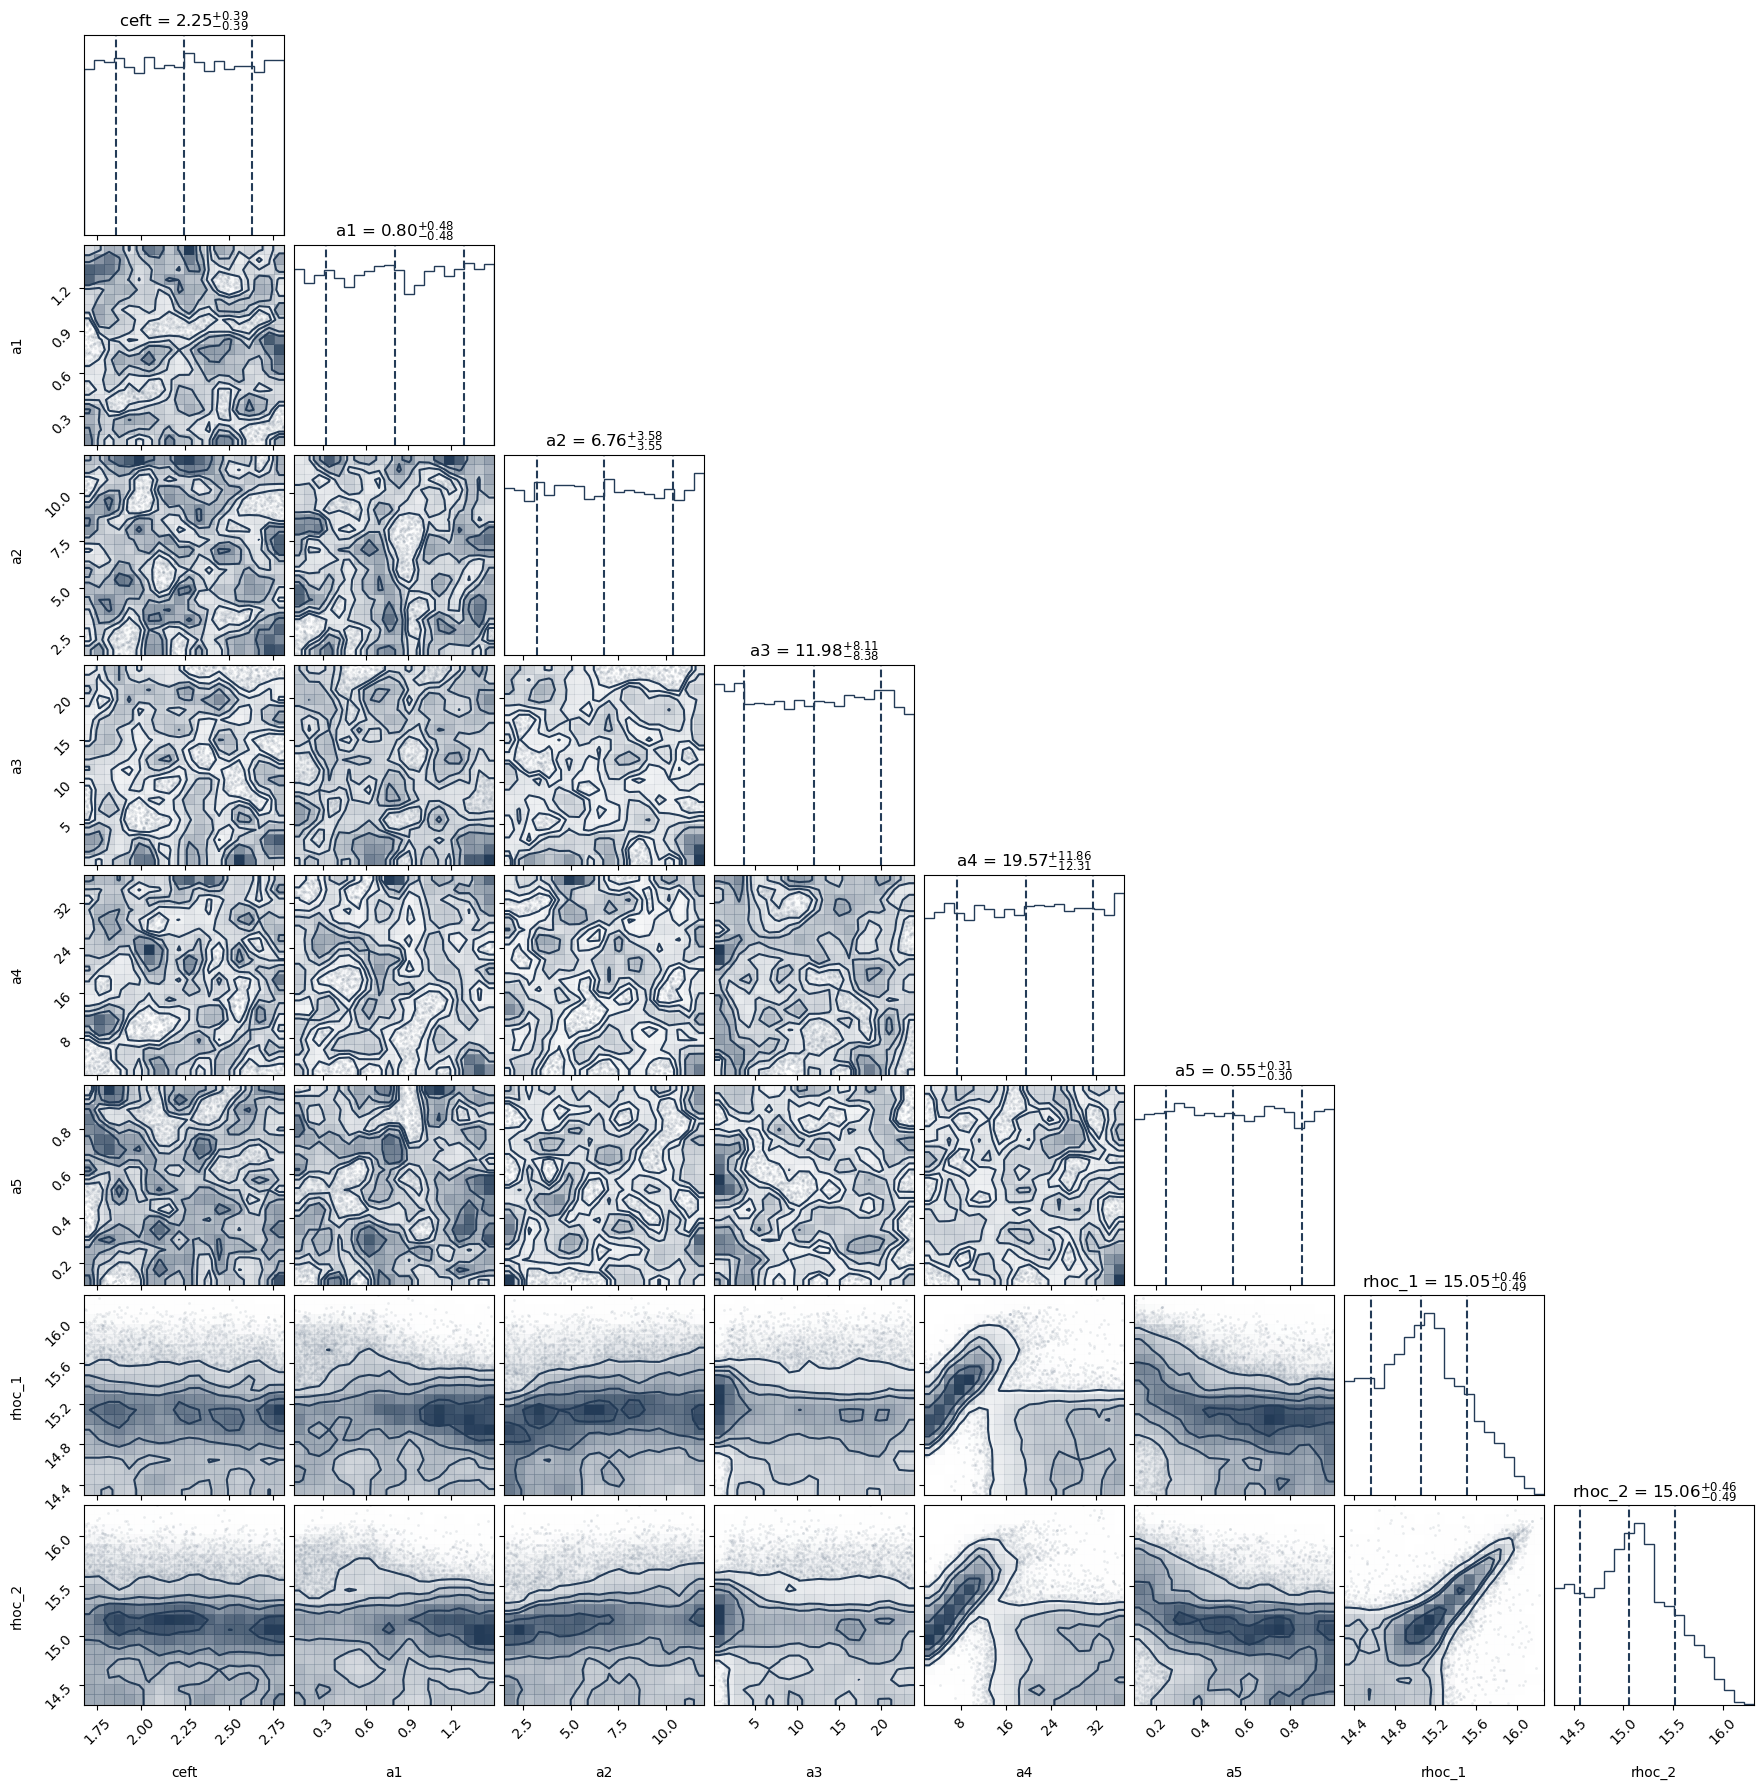

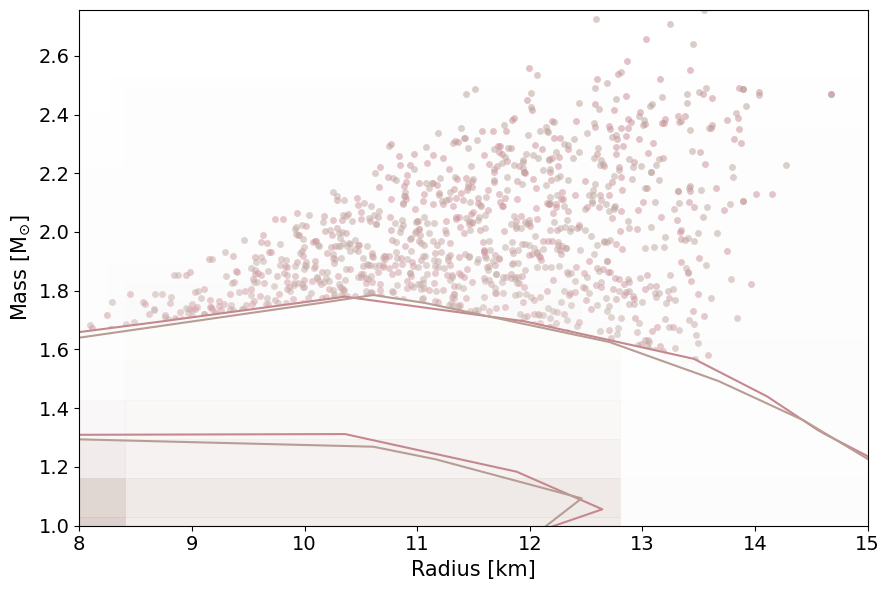

In [7]:
# Compute auxiliary data for posterior analysis
PosteriorAnalysis.compute_auxiliary_data('../../examples/chains/' + run_name, speedofsound_cs,
                                         variable_params, static_params, chirp_mass)


# Make some analysis plots
PosteriorAnalysis.cornerplot('../../examples/chains/' + run_name, variable_params)
PosteriorAnalysis.mass_radius_posterior_plot('../../examples/chains/' + run_name)
PosteriorAnalysis.mass_radius_prior_predictive_plot('../../examples/chains/' + run_name,variable_params, label_name='+ J0740 dataset')
PosteriorAnalysis.eos_posterior_plot('../../examples/chains/' + run_name,variable_params)